# Comparing Preprocessing techniques for Gunshot detection

There are many different ways to input the signal's information into a machine learning model. This notebook provides a comparative study of the most performant ones to date in the case of a gunshot detection system. Instead of using `opensoundscape`, we will use `torchaudio` for its modularity and flexibility. Details of each processing method can be found on the final report. Also note that the goal of this study is rather to provide a reliable comparison of these methods in similar environement than to maximize performance of our model. The latter is done in the dedicated notebook `bestClassifier.ipynb` which combines the results of this notebook with the results from `architectureGunshot.ipynb`

## Environment Setup 

### Package Imports

In [1]:
# Machine Learning imports
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchvision.models import resnet18

# Processing imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Import the functions we designed to be used accross notebooks to avoid redundancies and improve clarity
from utils.common import list_files, create_dataframe, train_model, evaluate_model
from utils.datasets import BaseWaveformDataset, BaseSpectrogramDataset
from utils.modelsWaveform import CNN
from utils.plotsPreprocessing import plot_waveform, plot_spectrogram, plot_complex_spectrogram, \
plot_complex_spectrogram_3d, plot_fbank

### Global Variables

In [2]:
# Feel free to change the following in order to accommodate your environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mode = "training" if str(device) == "cuda" else "development" 
print(f"Notebook in {mode} mode")

np.random.seed(4) # For reproducibility of results

MODEL_DIR = "models/preprocessing"
TRAIN_PREFIX = "Data/Training data"
VAL_PREFIX   = "Data/Validation data"

SAMPLE_RATE = 8000

Notebook in development mode


### Training Parameters

In [3]:
batch_size = 128
num_workers = 8 if str(device) == "cuda" else 2
num_epochs = 30
lr = 0.001

### Data Loading

In [4]:
train_keys = list_files(TRAIN_PREFIX)
val_keys   = list_files(VAL_PREFIX)

train_df   = create_dataframe(train_keys)
val_df     = create_dataframe(val_keys)

# Creating a Sampler to account for the imbalance of the dataset
train_counts = train_df["label"].value_counts().to_dict()
val_counts = val_df["label"].value_counts().to_dict()
weights = train_df["label"].map(lambda x: 1.0 / train_counts[x])
sampler = WeightedRandomSampler(weights.tolist(), num_samples=len(weights), replacement=True)

print(f"Found {len(train_keys)} training audios ({train_counts[1]} gunshots, {train_counts[0]} backgrounds) and {len(val_keys)} validation audios ({val_counts[1]} gunshots, {val_counts[0]} backgrounds).")

Found 28790 training audios (597 gunshots, 28193 backgrounds) and 7190 validation audios (150 gunshots, 7040 backgrounds).


We continue by loading two random examples (a positive and a negative one) that we will use to display the effect of spectrograms throughout the notebook. Here, we also take advantage of the fact that initially, negative labels are at the head and positive labels are at the tail.

In [5]:
pos_index, neg_index = -np.random.randint(0,train_counts[1]), np.random.randint(0,train_counts[0])

## Preprocessing pipelines

### Raw Waveforms

In [6]:
train_wf = BaseWaveformDataset(train_df, augmentation=1)
val_wf = BaseWaveformDataset(val_df)

In [7]:
train_loader_wf = DataLoader(
    train_wf,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_wf = DataLoader(
    val_wf,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

#### Plotting examples

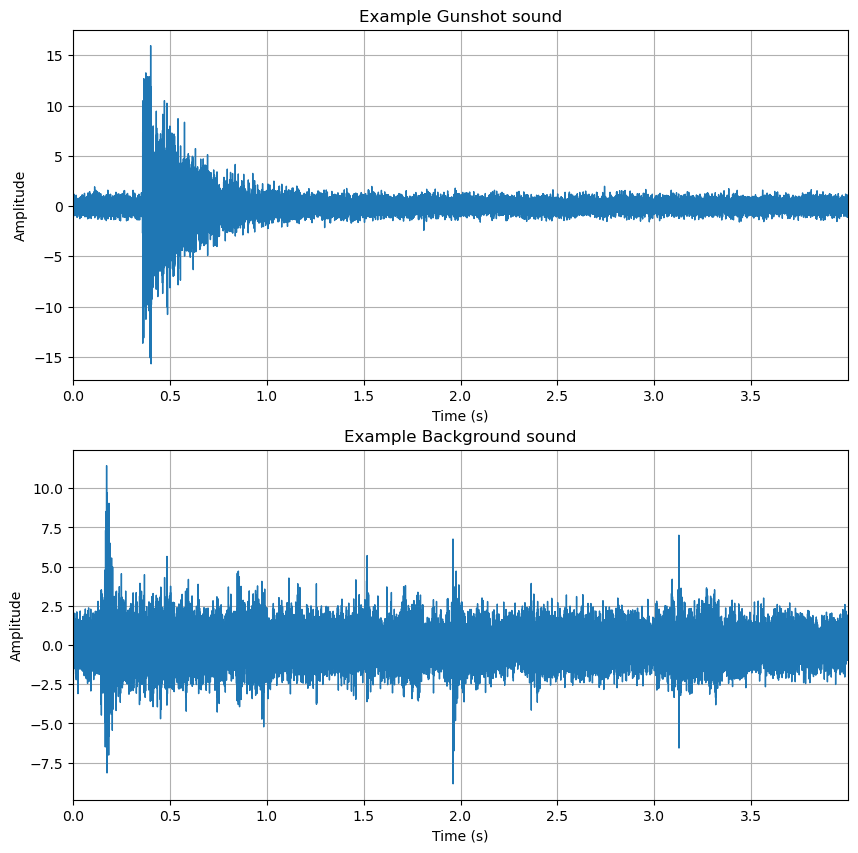

In [8]:
waveform_pos = train_wf[pos_index][0]
waveform_neg = train_wf[neg_index][0]

_, axes = plt.subplots(2, 1, figsize=(10,10))
plot_waveform(waveform_pos, SAMPLE_RATE, title=f"Example Gunshot sound", ax=axes[0])
plot_waveform(waveform_neg, SAMPLE_RATE, title=f"Example Background sound", ax=axes[1])

#### Building and training a model

To train our model for the raw waveform, we choose the a model from [this paper](arxiv.org/pdf/1610.00087). For our specific usecase, we choose the `m11` model whose design was optimized for these kinds of waveforms and which should be a very good option for gunshot detection.

In [9]:
model_wf = CNN(channels = [[64], [64]*2, [128]*2, [256]*3, [512]*2],
        conv_kernels = [80, 3, 3, 3, 3],
        conv_strides = [4, 1, 1, 1, 1],
        conv_padding = [38, 1, 1, 1, 1],
        pool_padding = [0, 0, 0, 2],
        num_classes  = 2)

output_path_waveform = os.path.join(MODEL_DIR, "best_waveform.pth")
output_path_waveform2 = os.path.join(MODEL_DIR, "last_waveform.pth")

In [10]:
if mode == "training":
    train_model(model_wf, train_loader_wf, val_loader_wf, output_path_waveform, output_path_waveform2, num_epochs, lr)

In [14]:
if mode == "training":
    evaluate_model("models/preprocessing/best_waveform.pth", val_loader_wf)

Evaluating: 100%|██████████| 57/57 [00:01<00:00, 52.79it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00      7040
     Gunshot       0.83      0.84      0.83       150

    accuracy                           0.99      7190
   macro avg       0.91      0.92      0.92      7190
weighted avg       0.99      0.99      0.99      7190


=== Performance Metrics ===
Accuracy: 0.9930
Precision: 0.8289
Recall: 0.8400
F1 Score: 0.8344

✅ Evaluation complete. Results saved in: evaluation/Run_20250310-1724


### Raw Spectrogram (complex-valued)

In [11]:
class RawSpectrogramDataset(BaseSpectrogramDataset):
    def process(self, waveform):
        spectrogram = T.Spectrogram(n_fft=1024,power=None)
        return spectrogram(waveform).squeeze(0)

train_raw_spec = RawSpectrogramDataset(train_df, augmentation=1)
val_raw_spec = RawSpectrogramDataset(val_df)

In [12]:
train_loader_raw_spec = DataLoader(
    train_raw_spec,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_raw_spec = DataLoader(
    val_raw_spec,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

#### Plotting examples
Here, as we are working with complex-valued spectrograms, we have to plot examples a slightly different ways:
1. **Magnitude & Phase plots**: We make two 2D plots. The first, given a complex value in the spectrogram array $x+iy$ simply redefines the complex value as $\sqrt{x^2+y^2}$ before coloring it. The second plot describes the angle that the complex value makes with the real axis; converting the $x+iy$ notation into the $re^{i\theta}$ notation, it redefines the complex value as $\theta$. Together, these two plot should give us a complete picture of the spectrogram
2. **Complex 3D plot**: We create a 3D colored plot where the x-axis represents time, the y-axis represents frequency, the z-axis represents the magnitude of the imaginary part of the complex value, and the color mapping represents the magnitude of the imaginary part. It should be able to encapsulate all of the information of the spectrogram in one plot.  

In [14]:
raw_spec_pos = train_raw_spec[pos_index][0]
raw_spec_neg = train_raw_spec[neg_index][0]

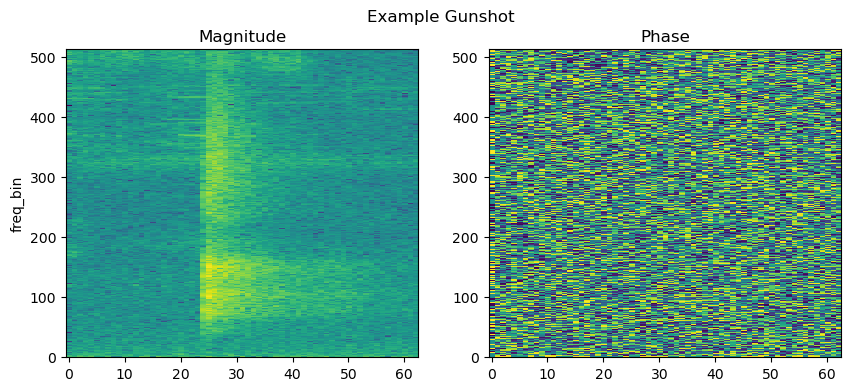

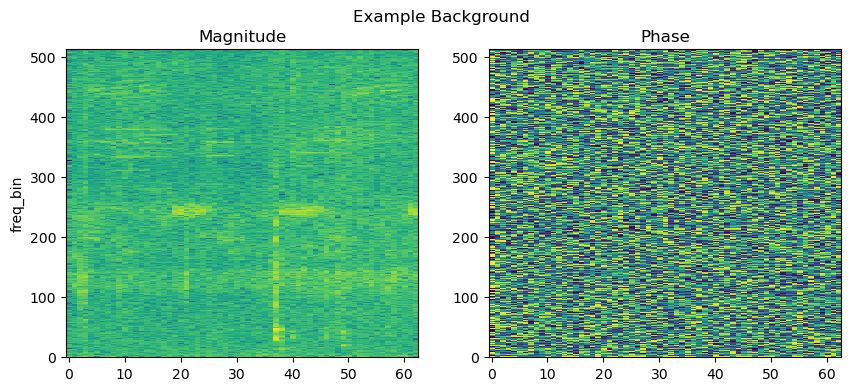

In [15]:
plot1 = plt.subplots(1, 2, figsize=(10,4))
plot2 = plt.subplots(1, 2, figsize=(10,4))
plot_complex_spectrogram(raw_spec_pos, title="Example Gunshot", plot=plot1)
plot_complex_spectrogram(raw_spec_neg, title="Example Background", plot=plot2)

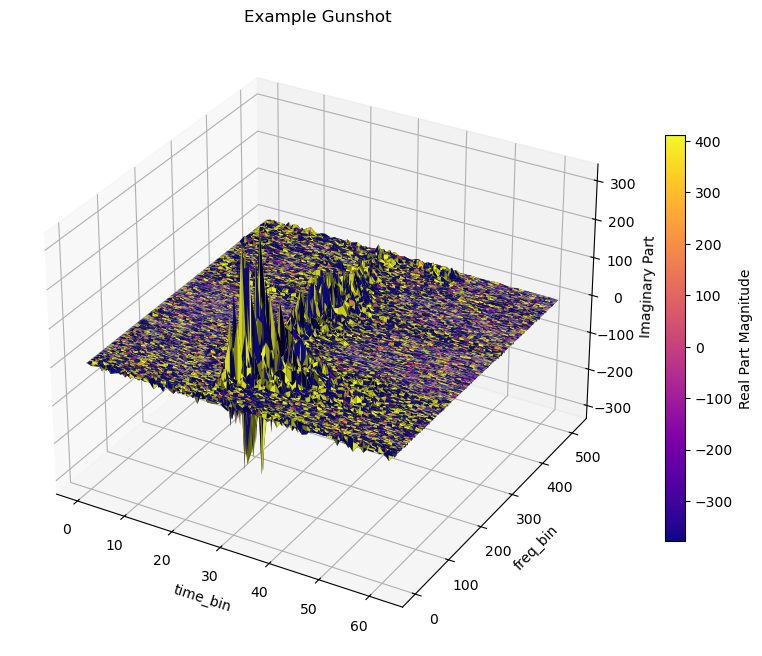

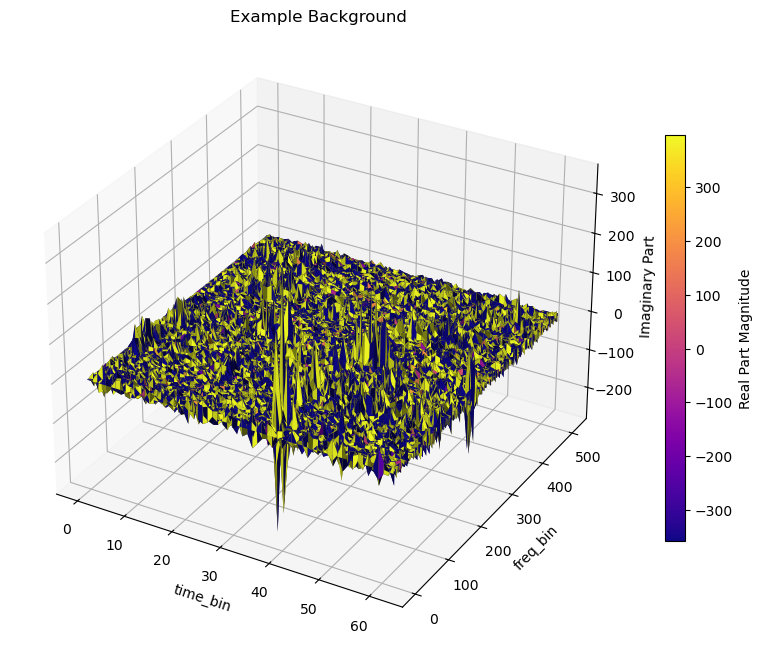

In [42]:
plot_complex_spectrogram_3d(raw_spec_pos, title="Example Gunshot")
plot_complex_spectrogram_3d(raw_spec_neg, title="Example Background")

#### Building and training a model

Typically, machine learning models for audio recognition convert complex-valued spectrograms into real-valued spectrograms before processing them. Due to time constraints, we were unable to delve into such mdoels and experiment the different options. In this case, there is therefore no point in training a model for a complex-valued spectrogram. We can simply proceed with the real-valued spectrogram directly as done below and leave this preprocessing method for future work. 

## Power Spectrogram (real-valued)

In [13]:
class PowSpectrogramDataset(BaseSpectrogramDataset):
    def process(self, waveform):
        spectrogram = T.Spectrogram(n_fft=512,power=2)
        return spectrogram(waveform)

train_pow_spec = PowSpectrogramDataset(train_df, augmentation=1)
val_pow_spec = PowSpectrogramDataset(val_df)

In [14]:
train_loader_pow_spec = DataLoader(
    train_pow_spec,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_pow_spec = DataLoader(
    val_pow_spec,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

#### Plotting examples

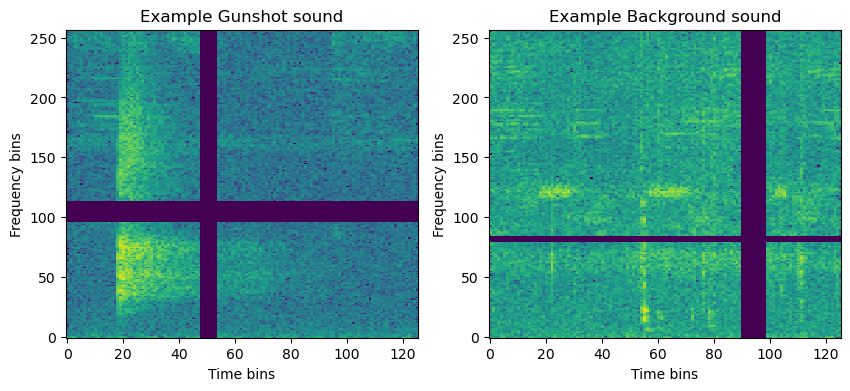

In [15]:
pow_spec_pos = train_pow_spec[pos_index][0].squeeze(0)
pow_spec_neg = train_pow_spec[neg_index][0].squeeze(0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_spectrogram(pow_spec_pos, title="Example Gunshot sound", ax=axes[0])
plot_spectrogram(pow_spec_neg, title="Example Background sound", ax=axes[1])

The difference now appears to be much more abvious and we can see the trace of the gunshot much better.

#### Building and training a model

ResNet18 appears to be a very option for our spectrograms. It offers a good depth trade-off and should be able to capture  the gunshot signature. For a more thorough comparison of the effect of architecture on performance, please feel free to refer to the `architectureGunshot.ipynb` file. The goal here is to obtain a performant and reliable classifier that enables effectve comparison between preprocessing techniques. 

Nonetheless, we perform minor modifications to the network's architecture to accommodate for our usecase. Sice a gunshot is a sudden occurence, we reduce the size of the initial kernel from $7\times 7$ to $5 \times 5$. In addition, we reduce the number of input channels to 1 since we are not working with RGB images. Lastly, we use transfer learning through pre-trained weights designed for image classification in order to enhance performance.

In [16]:
model_pow_spec = resnet18(weights="IMAGENET1K_V1")
model_pow_spec.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False)
model_pow_spec.fc = nn.Linear(model_pow_spec.fc.in_features, 2)

output_path_pow_spec = os.path.join(MODEL_DIR, "best_pow_spec.pth")
output_path_pow_spec2 = os.path.join(MODEL_DIR, "last_pow_spec.pth")

In [17]:
if mode == "training":
    train_model(model_pow_spec, train_loader_pow_spec, val_loader_pow_spec, output_path_pow_spec, output_path_pow_spec2, num_epochs, lr)

In [50]:
if mode == "training":
    evaluate_model("models/preprocessing/best_pow_spec.pth", val_loader_pow_spec)

Evaluating: 100%|██████████| 57/57 [00:04<00:00, 12.83it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00      7040
     Gunshot       0.88      0.83      0.85       150

    accuracy                           0.99      7190
   macro avg       0.94      0.91      0.92      7190
weighted avg       0.99      0.99      0.99      7190


=== Performance Metrics ===
Accuracy: 0.9940
Precision: 0.8794
Recall: 0.8267
F1 Score: 0.8522

✅ Evaluation complete. Results saved in: evaluation/Run_20250309-1616


### Linear-Frequency Cepstral Coefficients (LFCC)

In [18]:
class LFCCDataset(BaseSpectrogramDataset):
    def process(self, waveform):
        spectrogram = T.LFCC(sample_rate=SAMPLE_RATE)
        return spectrogram(waveform)

train_lfcc = LFCCDataset(train_df, augmentation=1)
val_lfcc = LFCCDataset(val_df)

In [19]:
train_loader_lfcc = DataLoader(
    train_lfcc,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_lfcc = DataLoader(
    val_lfcc,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

#### Plotting examples

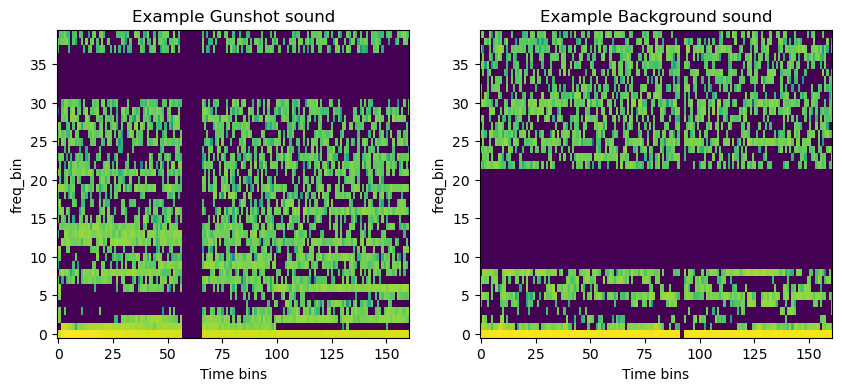

In [20]:
lfcc_pos = train_lfcc[pos_index][0].squeeze(0)
lfcc_neg = train_lfcc[neg_index][0].squeeze(0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_spectrogram(lfcc_pos, title=f"Example Gunshot sound", ylabel="freq_bin", ax=axes[0])
plot_spectrogram(lfcc_neg, title=f"Example Background sound", ylabel="freq_bin", ax=axes[1])

#### Building and training a model

In [21]:
model_lfcc = resnet18(weights="IMAGENET1K_V1")
model_lfcc.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False) 
model_lfcc.fc = nn.Linear(model_lfcc.fc.in_features, 2)

output_path_lfcc = os.path.join(MODEL_DIR, "best_lfcc.pth")
output_path_lfcc2 = os.path.join(MODEL_DIR, "last_lfcc.pth")

In [22]:
if mode == "training":
    train_model(model_lfcc, train_loader_lfcc, val_loader_lfcc, output_path_lfcc, output_path_lfcc2, num_epochs, lr)

In [63]:
if mode == "training":
    evaluate_model("models/preprocessing/best_lfcc.pth", val_loader_lfcc)

Evaluating: 100%|██████████| 57/57 [00:05<00:00,  9.56it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00      7040
     Gunshot       0.81      0.87      0.84       150

    accuracy                           0.99      7190
   macro avg       0.91      0.93      0.92      7190
weighted avg       0.99      0.99      0.99      7190


=== Performance Metrics ===
Accuracy: 0.9932
Precision: 0.8137
Recall: 0.8733
F1 Score: 0.8424

✅ Evaluation complete. Results saved in: evaluation/Run_20250309-1629


## Mel Spectrogram

In [23]:
class MelDataset(BaseSpectrogramDataset):
    def process(self, waveform):
        spectrogram = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=128, n_mels=64)
        return spectrogram(waveform)

train_mel_spec = MelDataset(train_df, augmentation=1)
val_mel_spec = MelDataset(val_df)

For visualisation purposes, we can display the mel filterbank for our mel spectrogram parameters

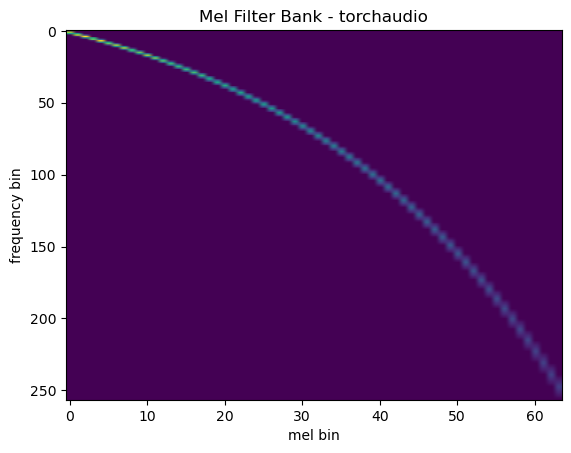

In [24]:
mel_filters = F.melscale_fbanks(
    int(512 // 2 + 1),
    n_mels=64,
    f_min=0.0,
    f_max=SAMPLE_RATE / 2.0,
    sample_rate=SAMPLE_RATE,
    norm="slaney",
)
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

In [25]:
train_loader_mel_spec = DataLoader(
    train_mel_spec,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_mel_spec = DataLoader(
    val_mel_spec,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

#### Plotting examples

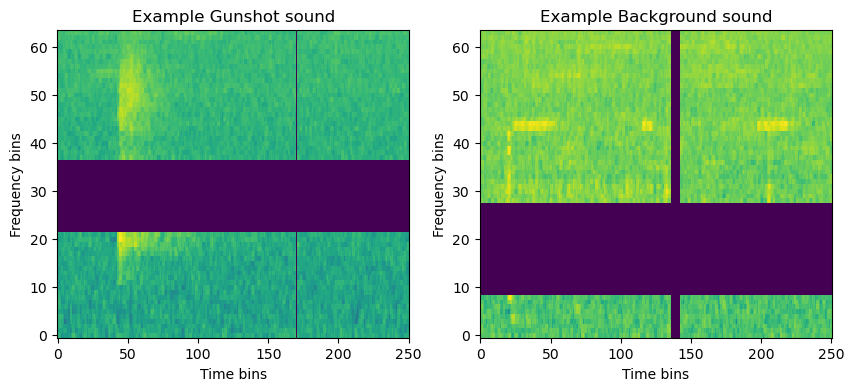

In [26]:
mel_spec_pos = train_mel_spec[pos_index][0].squeeze(0)
mel_spec_neg = train_mel_spec[neg_index][0].squeeze(0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_spectrogram(mel_spec_pos, title="Example Gunshot sound", ax=axes[0])
plot_spectrogram(mel_spec_neg, title="Example Background sound", ax=axes[1])

#### Building and training a model

In [27]:
model_mel_spec = resnet18(weights="IMAGENET1K_V1")
model_mel_spec.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False) 
model_mel_spec.fc = nn.Linear(model_mel_spec.fc.in_features, 2)

output_path_mel_spec = os.path.join(MODEL_DIR, "best_mel_spec.pth")
output_path_mel_spec2 = os.path.join(MODEL_DIR, "last_mel_spec.pth")

In [28]:
if mode == "training":
    train_model(model_mel_spec, train_loader_mel_spec, val_loader_mel_spec, output_path_mel_spec, output_path_mel_spec2, num_epochs, lr)

In [74]:
if mode == "training":
    evaluate_model("models/preprocessing/best_mel_spec.pth", val_loader_mel_spec)

Evaluating: 100%|██████████| 57/57 [00:03<00:00, 18.22it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00      7040
     Gunshot       0.92      0.82      0.87       150

    accuracy                           0.99      7190
   macro avg       0.96      0.91      0.93      7190
weighted avg       0.99      0.99      0.99      7190


=== Performance Metrics ===
Accuracy: 0.9949
Precision: 0.9248
Recall: 0.8200
F1 Score: 0.8693

✅ Evaluation complete. Results saved in: evaluation/Run_20250309-1641


## Mel-Frequency Cepstral Coefficients (MFCC)

In [29]:
class MFCCDataset(BaseSpectrogramDataset):
    def process(self, waveform):
        spectrogram = T.MFCC(sample_rate=SAMPLE_RATE,
            n_mfcc=32,
            log_mels=True,
            melkwargs={
                "n_fft": 1024,
                "n_mels": 32,
                "hop_length": 512,
                "mel_scale": "htk",
            },
        )
        return spectrogram(waveform)

train_mfcc = MFCCDataset(train_df, augmentation=1)
val_mfcc = MFCCDataset(val_df)

In [30]:
train_loader_mfcc = DataLoader(
    train_mfcc,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_mfcc = DataLoader(
    val_mfcc,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

#### Plotting examples

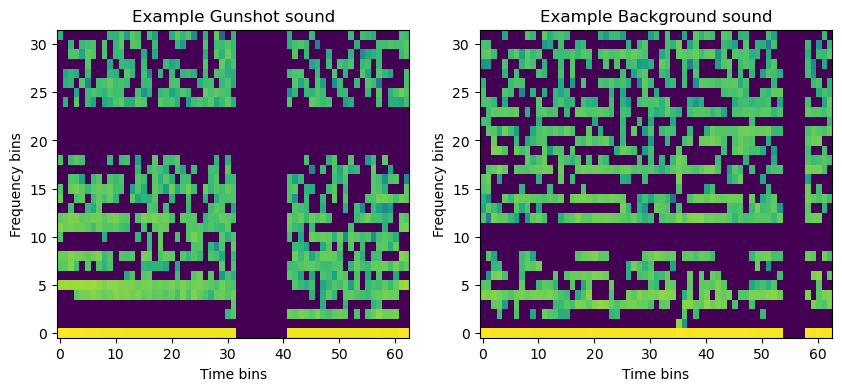

In [31]:
mfcc_pos = train_mfcc[pos_index][0].squeeze(0)
mfcc_neg = train_mfcc[neg_index][0].squeeze(0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_spectrogram(mfcc_pos, title="Example Gunshot sound", ax=axes[0])
plot_spectrogram(mfcc_neg, title="Example Background sound", ax=axes[1])

#### Building and training a model

In [32]:
model_mfcc = resnet18(weights="IMAGENET1K_V1")
model_mfcc.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False) 
model_mfcc.fc = nn.Linear(model_mfcc.fc.in_features, 2)

output_path_mfcc = os.path.join(MODEL_DIR, "best_mfcc.pth")
output_path_mfcc2 = os.path.join(MODEL_DIR, "last_mfcc.pth")

In [33]:
if mode == "training":
    train_model(model_mfcc, train_loader_mfcc, val_loader_mfcc, output_path_mfcc, output_path_mfcc2, num_epochs, lr)

In [82]:
if mode == "training":
    evaluate_model("models/preprocessing/best_mfcc.pth", val_loader_mfcc)

Evaluating: 100%|██████████| 57/57 [00:02<00:00, 21.45it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      0.99      0.99      7040
     Gunshot       0.70      0.87      0.78       150

    accuracy                           0.99      7190
   macro avg       0.85      0.93      0.89      7190
weighted avg       0.99      0.99      0.99      7190


=== Performance Metrics ===
Accuracy: 0.9896
Precision: 0.7027
Recall: 0.8667
F1 Score: 0.7761

✅ Evaluation complete. Results saved in: evaluation/Run_20250309-1647
